# Modeling

- TODO: add notebook description
- TODO: add explanations and comments
- TODO: add docstring in functions

## Table of contents:

* [1. Building and evaluating of a simple estimator](#1)
    * [1.1 Building and evaluating of a simple estimator](#1.1) 
    * [1.2 Data preprocessing](#1.2) 
    * [1.3 Split train/eval sets](#1.3) 
    * [1.4 Train an XGBoost regressor](#1.4) 
    * [1.5 Evaluate the model](#1.5) 
    * [1.6 Make predictions on the test set](#1.6) 
* [2. Proposing another model and strategy to increase performances](#2)
    * [2.1 Data loading](#2.1) 
    * [2.2 Data preprocessing for FBProphet model](#2.2)
    * [2.3 Split train/eval sets](#2.3)
    * [2.4 Train a univariate model for business unit 64 in department 127](#2.4)
    * [2.5 Make forecasts and evaluate the model](#2.5)
    * [2.6 Train and save all models](#2.6)


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import time
from tqdm.notebook import tqdm

import xgboost as xgb
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.serialize import model_to_json, model_from_json

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import holidays

import warnings

warnings.filterwarnings('ignore')

In [3]:
# Global variable for data relative path
DATA_PATH = os.path.abspath("../data/inputs")
RESULTS_PATH = os.path.abspath("../data/outputs")
TRAINED_MODELS_PATH = os.path.abspath("../trained_models")

## 1. Building and evaluating of a simple estimator <a class="anchor" id="1"></a>

### 1.1 Data loading <a class="anchor" id="1.1"></a>

In [4]:
data_train = pd.read_csv(os.path.join(DATA_PATH, "train", "train.csv"))
data_test = pd.read_csv(os.path.join(DATA_PATH, "test", "test.csv"))

### 1.2 Data preprocessing <a class="anchor" id="1.2"></a>

In [4]:
def process_dates(data):
    # dates preprocessing
    data["year"] = data.day_id.dt.year
    data["month"] = data.day_id.dt.month
    data["week"] = data.day_id.dt.isocalendar().week
    data["quarter"] = data.day_id.dt.quarter

    #either a day in the weekly turnover belongs to a holiday
    data["is_holiday"] = is_holiday_week(data).astype(int)

    return data

In [5]:
def one_hot_encoding(data, categorical_columns, training=True):
    """add one hot encoding of categorical columns"""

    if training:
        global ohe  # not recommended doing so, but it's the simplest solution
        ohe = OneHotEncoder()
        one_hot_encoded_data = ohe.fit_transform(data[categorical_columns])

    else:
        one_hot_encoded_data = ohe.transform(data[categorical_columns])

    one_hot_df = pd.DataFrame(one_hot_encoded_data.toarray(),
                              columns=ohe.get_feature_names_out(),
                              index=data.index)

    return one_hot_df

In [6]:
def add_turnover_lags(data, time_lag=4):
    """add historical data of the last time_lag year"""

    # add empty columns to fill lags
    for i in range(time_lag):
        lag = np.empty(data.shape[0])
        lag[:] = np.nan
        data["turnover_N-{}".format(i + 1)] = lag

    # get the list of departments and stores
    business_units_list = data.but_num_business_unit.unique()
    department_list = data.dpt_num_department.unique()

    # ingest lags by store and by department
    for i in business_units_list:
        for j in department_list:
            for k in range(1, time_lag + 1):
                lag_data = data.loc[
                    (data.but_num_business_unit == i) & (data.dpt_num_department == j), "turnover"].shift(-52 * k)
                if lag_data.shape != 0:
                    data.loc[lag_data.index, "turnover_N-{}".format(k)] = lag_data

    return data

In [7]:
def is_holiday_week(data):
    #get holiday dates in France from 2012 to 2017
    holidays_france = pd.DataFrame(
        holidays.France(years=range(2012, 2018)).keys(),
        dtype="datetime64[ns]",
        columns=["holiday_date"])

    # make a tuple of (year, week of year)
    holidays_france["year"] = holidays_france["holiday_date"].dt.year
    holidays_france["week"] = holidays_france["holiday_date"].dt.isocalendar().week

    year_week_tuple = list(holidays_france[["year", "week"]].itertuples(index=False, name=None))

    # check each row in the data if it belongs to (year, week of the year) tuple
    return pd.Series(list(zip(data.year, data.week)), index=data.index).isin(year_week_tuple)

In [8]:
def process_data(data, categorical_columns, training=True, time_lag=4):
    # set day_id adequate type
    data["day_id"] = pd.to_datetime(data["day_id"], infer_datetime_format=True)

    # sort data by day_id 
    data.sort_values("day_id", ascending=False, inplace=True)

    # process dates
    _ = process_dates(data)

    # add time lags 
    add_turnover_lags(data, time_lag=time_lag)

    # one hot encoding
    one_hot_encoded_data = one_hot_encoding(data, categorical_columns, training)

    # drop old categorical columns
    data.drop(columns=categorical_columns, inplace=True)

    #concat with the one hot encoded ones
    data = pd.concat([data, one_hot_encoded_data], axis=1)

    return data


In [9]:
categorical_columns = ["dpt_num_department", "but_num_business_unit", "year", "month", "week", "quarter"]

data_train = process_data(data_train, categorical_columns= categorical_columns, training=True)

### 1.3 Split train/eval sets <a class="anchor" id="1.3"></a>


In [10]:
# train on all data except the last month
train_idx = data_train.day_id.dt.date <= datetime(year=2017, month=8, day=31).date()

In [11]:
X = data_train.drop(labels=['turnover', "day_id"], axis=1)
y = data_train['turnover']

In [12]:
X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_eval, y_eval = X.loc[~train_idx], y.loc[~train_idx]

In [13]:
print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_eval shape: {}, y_eval shape: {}".format(X_eval.shape, y_eval.shape))

X_train shape: (271369, 406), y_train shape: (271369,)
X_eval shape: (6350, 406), y_eval shape: (6350,)


### 1.4 Train an XGBoost regressor <a class="anchor" id="1.4"></a>

Since Xgboost deals with missing values, we will not remove these

In [14]:
xgb_reg = xgb.XGBRegressor(n_estimators=200, n_jobs=-1, max_depth=20, verbosity=1, random_state=42)

In [15]:
xgb_reg.fit(X_train.astype(float), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

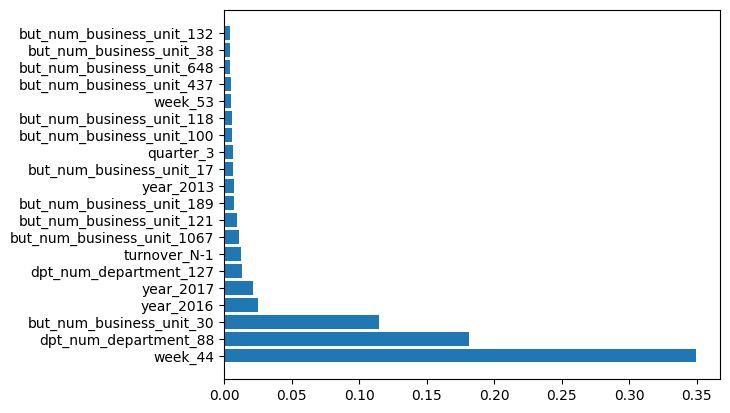

In [16]:
#plot features importance
feature_importances = pd.Series(xgb_reg.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_20_features = feature_importances[:20]
_ = plt.barh(top_20_features.index, top_20_features)

In [17]:
# save the model 
save_path = os.path.join(TRAINED_MODELS_PATH, "XGBoost","XGBoost_{}".format(time.strftime("%Y%m%d-%H%M%S")))
xgb_reg.save_model(save_path)
print("Model saved at: {}".format(save_path))

Model saved at: /home/jupyter/decathlon_challenge/trained_models/XGBoost/XGBoost_20230102-010307


### 1.5 Evaluate the model <a class="anchor" id="1.4"></a>

We will use for evaluation MAE and MSE

In [18]:
# get the predictions
y_pred = xgb_reg.predict(X_eval.astype(float))

In [19]:
print("MAE for eval data: {:.2f}".format(mean_absolute_error(y_eval, y_pred)))
print("MSE for eval data: {:.2f}".format(mean_squared_error(y_eval, y_pred)))

MAE for eval data: 65.24
MSE for eval data: 14824.24


### 1.6 Make predictions on the test set <a class="anchor" id="1.5"></a>

In [20]:
def preprocess_test_data(test_data, historical_data_path):
    """get historical data from data_train"""

    # add an empty turnover column
    empty_column = np.empty(test_data.shape[0])
    empty_column[:] = np.nan
    test_data["turnover"] = empty_column

    historical_data = pd.read_csv(historical_data_path)

    return pd.concat([historical_data, test_data], axis=0, ignore_index=True)

In [21]:
# preprocess test_data and add historical data
data_test = preprocess_test_data(data_test, os.path.join(DATA_PATH, "train", "train.csv"))

#make a copy of data_test
data_test_copy = data_test[data_test["turnover"].isna()].copy()

#process data_test
data_test = process_data(data_test, categorical_columns= categorical_columns, training=False)

#drop train data and get final data_test
data_test = data_test[data_test["turnover"].isna()]

In [22]:
#Get X_test data
X_test = data_test.drop(columns=["turnover", "day_id"])
print("X_test shape: {}".format(X_test.shape))

X_test shape: (10136, 406)


In [23]:
#make predictions
y_pred = xgb_reg.predict(X_test.astype(float))

# concat y_pred with X_test
y_pred = pd.DataFrame(y_pred, columns=["turnover_pred"], index=data_test.index)
results = pd.concat([data_test_copy, y_pred], axis=1)
results.head()

,day_id,but_num_business_unit,dpt_num_department,turnover,turnover_pred
277719,2017-11-25,95,73,NaN,-5.315661
277720,2017-11-25,4,117,NaN,1241.183350
277721,2017-11-25,113,127,NaN,798.416138
277722,2017-11-25,93,117,NaN,665.324524
277723,2017-11-25,66,127,NaN,1682.889038


In [24]:
# save predictions
save_path = os.path.join(RESULTS_PATH, "xgboost_predictions.csv")

results.to_csv(save_path)
print("Predictions saved at: {}".format(save_path))

Predictions saved at: /home/jupyter/decathlon_challenge/data/outputs/xgboost_predictions.csv


## 2. Proposing another model and strategy to increase performances <a class="anchor" id="2"></a>

To improve the results, we can use a multivariate time series strategy to forecast future revenue over eight weeks. The advantage of the multivariate time series model, in addition to dealing with temporality, is that it can also take advantage of the correlation between stores to improve performance.


Due to lack of time, we will implement a univariate time series approach. For that, we chose to use FBProphet for rapid developmen where we train each model on a tuple of (department, business unit) turnover. 

Let's first take as an example the turnover of business unit 64 in department 127. Then we will train all models of all business units and save them to local disk

### 2.1 Data loading <a class="anchor" id="2.1"></a>

In [3]:
data_train = pd.read_csv(os.path.join(DATA_PATH, "train", "train.csv"))
data_test = pd.read_csv(os.path.join(DATA_PATH, "test", "test.csv"))

# set day_id adequate type
data_train["day_id"] = pd.to_datetime(data_train["day_id"], infer_datetime_format=True)
data_test["day_id"] = pd.to_datetime(data_test["day_id"], infer_datetime_format=True)

### 2.2 Data preprocessing for FBProphet model <a class="anchor" id="2.2"></a>

In [4]:
def process_data_prophet(data, num_business_unit, num_department):
    """transform data into FBProphet adequate format"""

    data_prophet = data.loc[:, ['day_id', 'turnover']].rename(columns={"day_id": "ds", 'turnover': 'y'})
    idx_dep_store = (data.but_num_business_unit == num_business_unit) & (data.dpt_num_department == num_department)
    return data_prophet[idx_dep_store]

In [5]:
def get_holidays(years=range(2012, 2024)):
    """Get holidays in France"""

    holiday = pd.DataFrame([])
    for date, name in sorted(holidays.France(years=years).items()):
        holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "FR-Holidays"}, index=[0])],
                            ignore_index=True)
    holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
    
    return holiday

In [6]:
# get one department and one business unit data and transform data to adequat format for FBProphet 
data_prophet = process_data_prophet(data_train, num_business_unit=64, num_department=127)
data_prophet.head()

,ds,y
0,2017-09-30,580.308443
1845,2017-09-23,666.932164
3200,2017-09-16,915.977585
4533,2017-09-09,814.823360
5349,2017-09-02,836.789133


In [7]:
#get holidays in France
holidays_df = get_holidays()
holidays_df.head()

,ds,holiday
0,2012-01-01,FR-Holidays
1,2012-04-09,FR-Holidays
2,2012-05-01,FR-Holidays
3,2012-05-08,FR-Holidays
4,2012-05-17,FR-Holidays


### 2.3 Split train/eval sets <a class="anchor" id="2.3"></a>

In [8]:
def train_eval_split(data, year, month, day):
    # train on all data except the last month
    
    train_idx = data_train.day_id.dt.date <= datetime(year=year, month=month, day=day).date()

    return data[train_idx], data[~train_idx]

In [9]:
prophet_train, prophet_eval = train_eval_split(data_prophet, year=2017, month=8, day=31)
print("Prophet_train shape: {}, Prophet-eval shape: {}".format(prophet_train.shape, prophet_eval.shape))

Prophet_train shape: (244, 2), Prophet-eval shape: (5, 2)


### 2.4 Train a univariate model for business unit 64 in department 127 <a class="anchor" id="2.4"></a>

In [10]:
def train_prophet_model(data, holidays_df=None):
    m = Prophet(  #yearly_seasonality=True, #weekly_seasonality=False, #daily_seasonality=False,
        holidays=holidays_df,
        changepoint_prior_scale=0.03,
        n_changepoints=100,
        interval_width=0.9,
    )
    m.fit(data)
    return m

In [11]:
m = train_prophet_model(prophet_train, holidays_df)

01:42:13 - cmdstanpy - INFO - Chain [1] start processing
01:42:13 - cmdstanpy - INFO - Chain [1] done processing


### 2.5 Make forecasts and evaluate the model <a class="anchor" id="2.5"></a>

In [12]:
def make_forecasts(m, periods=10, freq="W", plot_forecasts=True, plot_components=True):
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast = m.predict(future)
    if plot_forecasts: plot_plotly(m, forecast).show("png")
    if plot_components: plot_components_plotly(m, forecast).show("png")
    return forecast

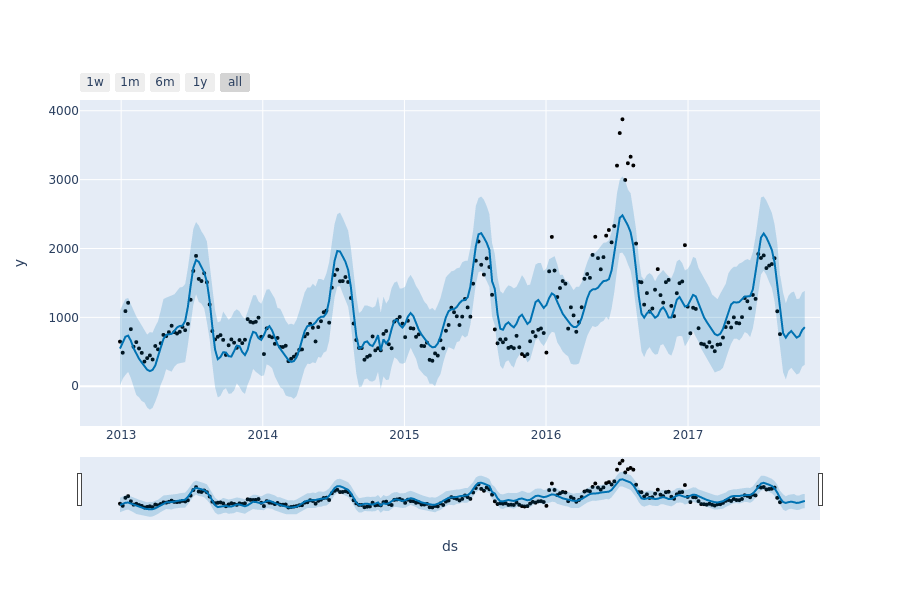

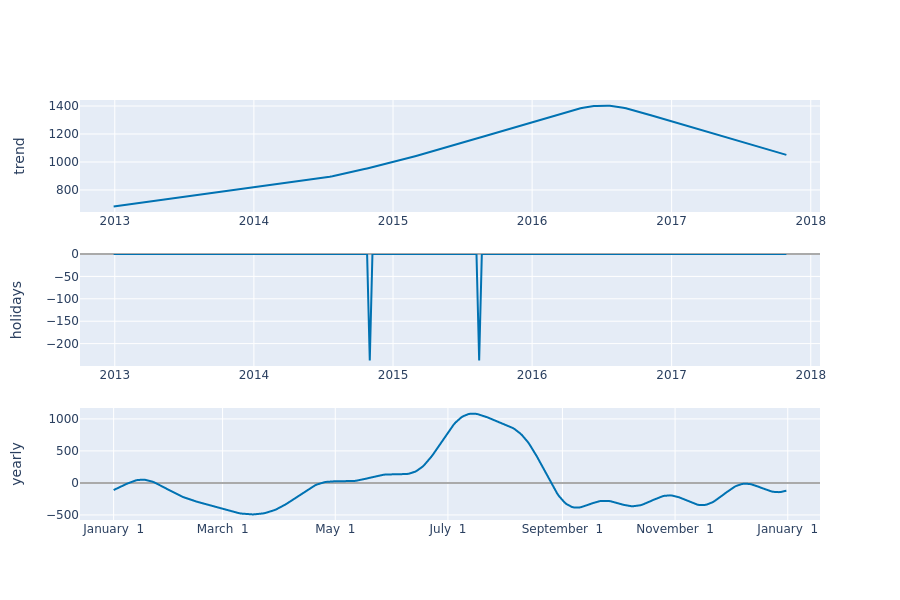

In [13]:
forecast = make_forecasts(m, plot_forecasts=True, plot_components=True)

In [36]:
def get_yhat(data_eval, forecast):
    """getting predictions from prophet forecasts"""
    
    results = pd.merge(data_eval, forecast, how='inner',
                       left_on=[data_eval.ds.dt.year, data_eval.ds.dt.isocalendar().week],
                       right_on=[forecast.ds.dt.year, forecast.ds.dt.isocalendar().week])
    results.index = data_eval.index
    
    return results

In [37]:
results = get_yhat(prophet_eval, forecast)
results[["ds_x", "yhat_lower", "yhat_upper", "y", "yhat"]]

,ds_x,yhat_lower,yhat_upper,y,yhat
0,2017-09-30,191.250172,1273.483645,580.308443,757.856240
1845,2017-09-23,214.395914,1320.449022,666.932164,801.327197
3200,2017-09-16,235.568896,1297.364673,915.977585,764.938796
4533,2017-09-09,159.637048,1272.381078,814.823360,705.944806
5349,2017-09-02,240.633254,1319.616639,836.789133,770.078452


In [38]:
print("MAE for business unit {}, department {} is: {}".format(127, 64, mean_absolute_error(results["y"], results["yhat"]))
     )

MAE for business unit 127, department 64 is: 127.71417092996255


### 2.6 Train and save all models <a class="anchor" id="2.6"></a>

In [39]:
def train_univariate_models(train_data, save_path, eval_start_date:date, holiday=None):
    
    #create a folder to save trained models
    if not os.path.exists(os.path.join(save_path, "FBProphet")): os.makedirs(
        os.path.join(save_path, "FBProphet"))
    
    # get the list of departments and business_units
    business_units_list = data_train.but_num_business_unit.unique()
    department_list = data_train.dpt_num_department.unique()
    
    # train a model per business unit and per department. Make eval forecasts for each model at the same time
    forecasts = pd.DataFrame()
    
    for business_unit in tqdm(business_units_list):
        for department in department_list:
            
            #transform data into prophet format
            data_prophet = process_data_prophet(data_train, business_unit, department)
            
            #check if business unit and department exist
            if data_prophet.shape[0] != 0:
                
                prophet_train, prophet_eval = train_eval_split(
                    data_prophet, year=eval_start_date.year, month=eval_start_date.month, day=eval_start_date.day)

                m = train_prophet_model(prophet_train, holidays_df)

                #save model to local disk
                model_path = os.path.join(
                    save_path, "FBProphet", "model_department_{}_business_unit_{}".format(department, business_unit))
                with open(model_path, 'w') as file_out: file_out.write(model_to_json(m))

                
                bs_dpt_forecast = make_forecasts(m, plot_forecasts=False, plot_components=False)

                results = get_yhat(prophet_eval, bs_dpt_forecast)
                forecasts = pd.concat([forecasts, results], axis=0)
    return forecasts

In [ ]:
forecasts = train_univariate_models(data_train, TRAINED_MODELS_PATH, eval_start_date= date(2017, 8, 31), holiday=holidays_df)

In [43]:
forecasts[["ds_x", "yhat_lower", "yhat_upper", "y", "yhat"]]

,ds_x,yhat_lower,yhat_upper,y,yhat
0,2017-09-30,223.773385,1312.127868,580.308443,757.856240
1845,2017-09-23,270.408391,1368.344652,666.932164,801.327197
3200,2017-09-16,216.809458,1316.973085,915.977585,764.938796
4533,2017-09-09,160.711823,1241.521871,814.823360,705.944806
5349,2017-09-02,252.258863,1337.113010,836.789133,770.078452
...,...,...,...,...,...
1231,2017-09-30,-0.087626,0.076440,0.000000,-0.001915
1272,2017-09-23,-0.086822,0.073847,0.000000,-0.005981
3458,2017-09-16,-0.087901,0.073125,0.000000,-0.009185
3841,2017-09-09,-0.089894,0.073863,0.000000,-0.007189


In [44]:
print("The Global MAE is: {}".format(mean_absolute_error(forecasts["y"], forecasts["yhat"])))

The Global MAE is: 97.78938933834613


The results are less good than the XGboost model, this is due to the hyperparameters adjustment of the models, which I did not have time to do correctly. But, in general and based on the EDA FBProphet can do much better with more working time